# Capstone project 1: Pet Product Auto-Subcategorization by Review Analysis (preprocessing)

**Goal: Creating a system that automatically classifies products in Pet Supplies category into subcategories by analyzing the reviews.**  
In this project, the data collected during 2014 - 2015 in the US is used.

## 1. Loading Data

In [1]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv

sns.set(context='notebook', style='ticks', palette='hls')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

The dataset is available on https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Pet_Products_v1_00.tsv.gz

In [3]:
# Load the tsv file with columns which will be used
data = pd.read_table('amazon_reviews_us_Pet_Products_v1_00.tsv', usecols=[0,4,5,6,13,14])
data.head()

,marketplace,product_parent,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [4]:
# Change the clomun label from 'product_parent' to 'product_id'
data = data.rename(columns={'product_parent':'product_id'})
data.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [5]:
# Check the general information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639981 entries, 0 to 2639980
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   marketplace       object
 1   product_id        int64 
 2   product_title     object
 3   product_category  object
 4   review_body       object
 5   review_date       object
dtypes: int64(1), object(5)
memory usage: 120.8+ MB


In [6]:
# Is there any missing date?: Yes
data.isnull().any(axis=0)

marketplace         False
product_id          False
product_title        True
product_category    False
review_body          True
review_date          True
dtype: bool

## 2. Data Wrangling

#### Approach:

2.1. Extracting data collected in 2014 or 2015  
2.2. Removing columns having a single value  
2.3. Dealing with missing values and duplicate data  
2.4. Removing short and long reviews    
2.5. Adjusting the number of reviews per product  
2.6. Merging reviews to the same product in one  
2.7. Tokenization  
2.8. Retaining only alphabets  
2.9. Removing stop words  
2.10. Stemming and lemmatization  
2.11. Retaining only nouns  
2.12. Removing words appearing 4 times or less  
2.13. Removing products having 4 tokens or less

### 2.1. Extracting data collected in 2014 or 2015

In [7]:
# Extract data in 2015 (ignore data without a date label)
df_2015 = data[data['review_date'].str.contains('2015-', na=False)] 
df_2015.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [8]:
# Check the number of the rows
len(df_2015)

875524

In [9]:
# Extract data in 2014 (ignore data without a date label)
df_2014 = data[data['review_date'].str.contains('2014-', na=False)] 
df_2014.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
875589,US,384773221,Flea Control Killer 12 Monthly Capsules of Luf...,Pet Products,Been working good so far.,2014-12-31
875590,US,226765263,Four Paws Wee-Wee Pet Training and Puppy Pads,Pet Products,"Great pads, they work great! Also great value,...",2014-12-31
875591,US,698924655,Cockatiel Nutri-Berries,Pet Products,Got here faster loved it & my Quaker parrots L...,2014-12-31
875592,US,456586629,Willow Branch Ball for Small Animals,Pet Products,"Bunny likes it, but I'd like it to last longer.",2014-12-31
875593,US,438365490,Rubies Costume Rubies Princess Pet Costume,Pet Products,Too small for my german shepherd,2014-12-31


In [10]:
# Check the number of the rows
len(df_2014)

829705

In [11]:
# Merge the two dataframes
df_two_years = df_2015.append(df_2014)
df_two_years.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [12]:
# Count the number of the rows
len(df_two_years)

1705229

### 2.2. Removing columns having a single value

In [13]:
# Check if all 'marketplace' vlaues are 'US'
print(len(df_two_years[df_two_years['marketplace'] != 'US']))

# Check if all 'product_category' values are 'Pet Products'
print(len(df_two_years[df_two_years['product_category'] != 'Pet Products']))

0
0


There is no incorrect value. 

In [14]:
# Remove the two columns and 'review_date' column
df = df_two_years[['product_id', 'product_title', 'review_body']]
df.head()

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


### 2.3. Dealing with missing values and duplicate data

#### 2.3.1. Removing missing values

In [15]:
# How many products in df?
df['product_id'].nunique()

128995

In [16]:
# Is there any missing date?
df.isnull().sum()

product_id         0
product_title      0
review_body      216
dtype: int64

In [17]:
# If droping the rows having null, how many products will be removed?
df_dropna = df.dropna(how='any')
df['product_id'].nunique() - df_dropna['product_id'].nunique()

18

I have decided to remove these products from this model because a product without a review is not an active pruduct.  
The products are shown as a list for later.

In [18]:
# Extrct the products' names
products_df = df[['product_id', 'product_title']].drop_duplicates()
products_dropna = df_dropna[['product_id', 'product_title']].drop_duplicates()
null_reviews = products_df[~products_df['product_id'].isin(products_dropna['product_id'])]

# Set the index to 'product_id' column
null_reviews = null_reviews.set_index(['product_id']).sort_index()

# Show the list
print(null_reviews)

                                                product_title
product_id                                                   
59503872    {Factory Direct Sale} 100Pcs Set Poultry Leg B...
111888120   Genuine Leather Dog Harness, Medium. 25.5"-29"...
173421502   Dean & Tyler 26 to 37-Inch Strong Nylon Cobra ...
194817456   Generic New Pet Dog Cat Leather Spike Stud Col...
299399624   Mirage Pet Bitches Love Me Screen Print Dog Ba...
404027221   Mosunx(TM) Hot Pet Dog Puppy Tutu Princess Dre...
418434105   Saddle Bag Pet Dogs Backpack Travel Hiking Har...
490871023   Casual Canine Reindeer Hoodie for Dogs, 10" XS...
507641146   San Francisco Bay Brand Herp Instant Meal Turt...
556866786   The Dog Squad Minkie Binkie Pet Blanket, Mediu...
721172262              AquaTop Aquarium Air Blower, 180 Watts
761779284           Coral Pink Rosettes PETS Tutu Party Dress
767317796   MLB BANDANA - CLEVELAND INDIANS DOG BANDANA wi...
803837812                YAP Technology Dog Harness - Red (L)
82834048

Table1. No review products list

#### 2.3.2. Removing duplicate data

In [19]:
# Remove duplicate data: 8004 duplicate data
df_drop_dup = df_dropna.drop_duplicates()
len(df) - len(df_drop_dup)

8004

In [20]:
# Show the number of reviews in df_drop_dup
len(df_drop_dup)

1697225

In [21]:
# Show the number of products in df_drop_dup
df_drop_dup['product_id'].nunique()

128977

### 2.4. Removing short reviews

Short reviews might not have enough information to characterize the product. I am removing reviews having less than 30 characters.

In [22]:
# Count the number of characters in a review
review_length = df_drop_dup['review_body'].str.len()

In [23]:
# Show the summary statistics
review_length.describe()

count    1.697225e+06
mean     2.336816e+02
std      3.471153e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.360000e+02
75%      2.810000e+02
max      4.439900e+04
Name: review_body, dtype: float64

In [24]:
# 95 percentile
review_length.quantile(0.95)

760.0

In [25]:
# Create a count plot
length_counter = Counter(review_length)

plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.scatter(length_counter.keys(), length_counter.values(), c='lightcoral')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 45000 + 1, 5000))
plt.title('Number of characters / review')

plt.subplot(2,1,2)
plt.scatter(length_counter.keys(), length_counter.values(), c='lightcoral')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xlim([-10,800])
plt.xticks(np.arange(0, 800 + 1, 50))
plt.axvline(x=59, ymin=0, ymax=12500, c='navy', alpha=0.5, label='25%', ls=':')
plt.axvline(x=136, ymin=0, ymax=12500, c='navy', alpha=0.5, label='50%', ls='-.')
plt.axvline(x=281, ymin=0, ymax=12500, c='navy', alpha=0.5, label='75%', ls='--')
plt.axvline(x=760, ymin=0, ymax=12500, c='navy', alpha=0.5, label='95%', ls='-')
plt.title('Number of characters / review (from 0 to 800)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

95th percentile was 760 characters per review. I think 760 characters are enough to describe the products. Longer reviews will make the model complicated. Let's remove the longer reviews more than 760.

In [26]:
# Remove reviews longer than 760
df_less760_chara = df_drop_dup.query('review_body.str.len() <= 760')
len(df_less760_chara)

1612532

84,693 (1,697,225 - 1,612,532) reviews were removed.

In [27]:
# Check the reviews having only one character
df_less760_chara.query('review_body.str.len() == 1').head()

,product_id,product_title,review_body
1116,167929142,Littermaid Receptacles,f
2080,230993905,RFA-188 3-Volt Lithium Battery,k
2090,698234953,Instinct Grain Free All Natural Oven-Baked Bis...,1
3905,264157737,Nutramax Denamarin Supplemental Tablets,K
4407,350664549,PetSafe 6-Volt Lithium Battery (2 Batteries pe...,😀


In [28]:
# Check the reviews having two character
df_less760_chara.query('review_body.str.len() == 2').head()

,product_id,product_title,review_body
275,694724594,Tetra 77035 TetraFin Floating Variety Pellets,OK
2178,58740630,Giant Mealworms - Jumbo Mealworms for Feeding ...,:/
3837,78582590,Wahl Pet Clipper Hair Cutting Kit for touch up...,ok
4519,852092603,Yescom Aquarium Internal Filter 3in1 80GPH 300...,Ok
5002,666431592,Petvi all natural probiotic nutritional supple...,ok


In [29]:
# The number of the products removed
df_drop_dup['product_id'].nunique() - df_less760_chara['product_id'].nunique()

2210

2,210 products are 1.7% of the total.

Short reviews might not have enough information to characterize the product. I am removing reviews having fewer than 30 characters.

In [30]:
# Remove reviews having fewer than 30 characters
df_more30_chara = df_less760_chara.query('review_body.str.len() >= 30')
len(df_more30_chara)

1396300

216,232 (1,612,532 - 1,396,300) reviews were removed.

In [31]:
# The number of the products removed
df_less760_chara['product_id'].nunique() - df_more30_chara['product_id'].nunique()

9967

9,967 products is 7.7% of the total.
I am going to show the products removed as a table.

In [32]:
# Extrct the products' names
products_more30_chara = df_more30_chara[['product_id', 'product_title']].drop_duplicates()
short_reviews = products_dropna[~products_dropna['product_id'].isin(products_more30_chara['product_id'])]

# Set the index to 'product_id' column
short_reviews = short_reviews.set_index(['product_id']).sort_index()

# Save the list to a csv file
#short_reviews.to_csv(short_review_products_list)

# Show the list
short_reviews

,product_title
product_id,
13903,Mr Bites 9-Inch Rawhide Retriever Roll for Dog...
114505,"1000 Live Superworms-Reptile, Birds, Fishing B..."
125740,"JurassiDiet - Newt & Frog, 120 g / 4.2 oz."
210582,Marineland C-Series C-160 & C-220 Canister Fil...
320416,Pet Champion 1.25-Inch Cushion Herringbone Dog...
...,...
999682628,Tampa Bay Lightning Pet Dog Pink Performance T...
999703990,San Francisco Bay Brand ASF71120 Freeze Dried ...
999759324,Hartz Delectables Gourmet Treats for Cats Roas...


Table2. Short and long review products list

The number of the removed products should be 12,177, but 12,190.

In [33]:
# Check the number of products in short_reviews
short_reviews.index.nunique()

12177

The differenct was caused by some products having two different product titles.

In [34]:
# Show the number of reviews in df_more30_chara
len(df_more30_chara)

1396300

In [35]:
# Show the number of products in df_more30_chara
df_more30_chara['product_id'].nunique()

116800

Now, there are 1,396,300 observations (reviews) and 116,800 products. 

### 2.5. Adjusting the number of reviews per product

The number of reviews per product is adjusted to be five to make this model efficient. As the result, many products having few reviews are removed. These removed products would not be very active because they have a few reviews.

In [36]:
# Recheck df_more30_chara
df_more30_chara.head()

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


In [37]:
# Group by 'product_id' and count the number of reviews for each product
df_count_by_product = df_more30_chara[['product_id', 'review_body']].groupby('product_id').count()

# Change the column label
df_count_by_product.columns = ['number_of_reviews']

In [38]:
df_count_by_product.describe()

,number_of_reviews
count,116800.000000
mean,11.954623
std,62.215982
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,4285.000000


In [39]:
# 95 percentile
df_count_by_product.quantile(0.95)

number_of_reviews    42.0
Name: 0.95, dtype: float64

In [40]:
# Draw a strip plot and a count plot
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.hist(df_count_by_product['number_of_reviews'], bins=4285, cumulative=True, histtype='step', color='lightcoral')
plt.xlim([-50,4290])
plt.xticks(range(0,4300,250))
plt.xlabel('Number of reviews')
plt.ylabel('Cumulative count')
plt.title('Number of reviews / product')

plt.subplot(2,1,2)
sns.stripplot(x='number_of_reviews', data=df_count_by_product, size=3, color='steelblue', jitter=True)
plt.xlim([-50,4290])
plt.xticks(range(0,4300,250))
plt.xlabel('Number of reviews')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [41]:
# Draw a strip plot and a count plot
plt.figure(figsize=(5,4))

sns.countplot(x='number_of_reviews', data=df_count_by_product, color='lightcoral')
plt.xlim([-1,19])
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.title('Number of reviews / product (from 1 to 20)')

plt.subplots_adjust(left=0.2, right=0.90, bottom=0.2, top=0.90)
plt.show()

<IPython.core.display.Javascript object>

There are many products having a few reviews.

In [42]:
# Count the number of products having 5 or more reviews
df_count_more5 = df_count_by_product[df_count_by_product['number_of_reviews'] >= 5]
len(df_count_more5)

32353

In [43]:
# Extract rows which products have 5 or more reviews
df_more5 = df_more30_chara[df_more30_chara['product_id'].isin(df_count_more5.index)]
df_more5.head()

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


In [44]:
# Group by the index to get 5 reviews per product
df_more5_by_product = df_more5.groupby('product_id')

# Get 5 reviews per product
df_5_reviews = pd.DataFrame()
for product, group in df_more5_by_product:
    df_5_reviews = df_5_reviews.append(group.iloc[:5])
df_5_reviews.head(11)

,product_id,product_title,review_body
89134,17464,"Beastie Bands ZEBRA Cat Collar, Stripes","Safe, looks great, easily adjustable, affordab..."
208186,17464,"Beastie Bands ZEBRA Cat Collar, Stripes",I really like the Beastie Bands for my cats. ...
275354,17464,"Beastie Bands ZEBRA Cat Collar, Stripes",These have been great collars for my cats. St...
494203,17464,"Beastie Bands ZEBRA Cat Collar, Stripes",I LOVE these bands for convenience sake. Velc...
547782,17464,"Beastie Bands ZEBRA Cat Collar, Stripes",This Beastie Band collar was a good buy. It w...
108821,23478,YML Double Door Dog Kennel Cage with Plastic T...,Worked great - Good sturdy heavy duty cage.<br...
645534,23478,YML Double Door Dog Kennel Cage with Plastic T...,This is the perfect cage for our kitty to use ...
677375,23478,YML Double Door Dog Kennel Cage with Plastic T...,One of the latching bar's welding broke the in...
835512,23478,YML Double Door Dog Kennel Cage with Plastic T...,Very nice kennel. Bigger than I thought it wou...
1264002,23478,YML Double Door Dog Kennel Cage with Plastic T...,This crate sucks. My dog busted out of it. Def...


In [45]:
# Group by 'product_id' and count the number of reviews for each product
df_count_by_product_5 = df_5_reviews[['product_id','review_body']].groupby('product_id').count()

# Change the column label
df_count_by_product_5.columns = ['number_of_reviews']

# Check the distribution
df_count_by_product_5.describe()

,number_of_reviews
count,32353.0
mean,5.0
std,0.0
min,5.0
25%,5.0
50%,5.0
75%,5.0
max,5.0


Now, all products have 5 reviews.

In [46]:
# Count the number of reviews
len(df_5_reviews)

161765

In [47]:
# Check the number of products in df_reduced_reviews
df_5_reviews['product_id'].nunique()

32353

The products having 4 or less reviews are shown as a list.

In [48]:
# Extract rows which products have 4 or less reviews
products_less5 = products_more30_chara[~products_more30_chara['product_id'].isin(df_count_more5.index)]
products_less5 = products_less5.set_index(['product_id']).sort_index()
print(products_less5)

                                                product_title
product_id                                                   
3270        PETSOO Puppy Dog Pets Cute Winter Clothing Coa...
8072        YML Lot of 12 Clear Plastic Cup for Breeding C...
19343          PetSafe PIF00-12917 Stay & Play Wireless Fence
52250                        Living World Outdoor Bird Feeder
53358                           Ivermectin Sheep Drench 8 oz.
...                                                       ...
999931715                      Hand Puppet Dog Toy--ALLIGATOR
999961811   Tradewinds 8785 Canine Tapeworm Tablets - 5 x ...
999977146          Max's Closet 30413-M Red Solid Fancy Pants
999986033   Kakadu Pet Give a Dog a Bone Leather Dog Colla...
999991235   You Are Beautiful Believe In Yourself Dog Tag ...

[85004 rows x 1 columns]


Table3. Less review products list  

### 2.6. Merging reviews to the same product in one

In [49]:
# Merging reviews to the same product in one
df_by_product = df_5_reviews[['product_id', 'review_body']].groupby('product_id').sum()
df_by_product.head()

,review_body
product_id,
17464,"Safe, looks great, easily adjustable, affordab..."
23478,Worked great - Good sturdy heavy duty cage.<br...
52493,didn't care for the quality of these they are ...
70064,"Installed quick and easy, the template was wro..."
119780,My Chihuahua loves getting one of these specia...


In [50]:
# Make a 'product_id'-'product_title' table for later
id_name = df_5_reviews[['product_id', 'product_title']].groupby('product_id').sum()
print(id_name)

                                                product_title
product_id                                                   
17464       Beastie Bands ZEBRA Cat Collar, StripesBeastie...
23478       YML Double Door Dog Kennel Cage with Plastic T...
52493       Hartz Groomer's Best Pedicure Kit for Dogs and...
70064       Perfect Pet Soft Flap Cat Door with Telescopin...
119780      ARK Naturals PRODUCTS for PETS 326066 4-Ounce ...
...                                                       ...
999833933   Carlson Secure and Compact Single Door Metal D...
999879135   EzyDog Micro Doggy Flotation Device (DFD)EzyDo...
999917918   Farnam Horse Health Electrolytes SupplementFar...
999944581   KONG ZoomGroom, Dog Grooming Brush, SmallKONG ...
999976278   DoggyRide Original Dog Jogger-Stroller, Urban ...

[32353 rows x 1 columns]


Table4. Product id - name list

### 2.7. Tokenization

In [51]:
# Make a list of reviews
reviews_list = list(df_by_product['review_body'])
reviews_list[0]

"Safe, looks great, easily adjustable, affordable...I really like the Beastie Bands for my cats.  They won't wear any other kind.  The collars are soft, lightweight and don't have bells, which are not needed for our indoor cats.  They can be cut to fit, and even though one of my cats is very large, the collar fits.These have been great collars for my cats.  Stay on much better than standard collars.I LOVE these bands for convenience sake.  Velcro is the easiest way to get a collar on a skittish cat.<br /><br />HOWEVER... my cat just chews right through the material itself.  So, If you have a cat that is ok with these collars, they are GREAT... If not... You will find them on the floor. At least nylon collars are hard to chew through (again, a pro AND a con as these will stretch and rip off if caught up on something).This Beastie Band collar was a good buy.  It was easy to fit and works great."

In [52]:
# Tokenize the reviews
tokens_list = [nltk.word_tokenize(review) for review in reviews_list] 
tokens_list[0][:5]

['Safe', ',', 'looks', 'great', ',']

In [53]:
# Count the number of each word 
words_list_before = [token for review in tokens_list for token in review]
frequency_before = nltk.FreqDist(words_list_before)

# Sort the dictionary
frequency_before_sorted = dict(sorted(frequency_before.items(), key=lambda w: w[1]))

In [54]:
# Create a plot
plt.figure(figsize=(8,4))
sns.barplot(x=list(frequency_before_sorted.keys())[-30:], 
            y=list(frequency_before_sorted.values())[-30:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (before) (TOP 30)')
plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

<IPython.core.display.Javascript object>

There are many words that would not be useful to the model. I'm cleaning up the words.

In [55]:
# How many unique words?
before_word_number = len(set(token for review in tokens_list for token in review))
before_word_number

139193

In [56]:
# lower case
tokens_lower_list = [[token.lower() for token in review] for review in tokens_list]
tokens_lower_list[1][:5]

['worked', 'great', '-', 'good', 'sturdy']

In [57]:
# How many kind of words were removed?
lower_word_number = len(set(token for review in tokens_lower_list for token in review))
before_word_number - lower_word_number

19214

### 2.8. Retaining only alphabets 

In [58]:
# Retain alphabetic words
tokens_alpha_list = [[token for token in review if token.isalpha()] for review in tokens_lower_list]
tokens_alpha_list[1][:10]

['worked',
 'great',
 'good',
 'sturdy',
 'heavy',
 'duty',
 'br',
 'used',
 'it',
 'to']

In [59]:
# How many kind of words were removed?
alph_word_number = len(set(token for review in tokens_alpha_list for token in review))
lower_word_number - alph_word_number

66250

### 2.9. Removing stop words

In [60]:
# Remove all stop words
cached_stop_words = stopwords.words('english')
tokens_nostop_list = [[token for token in review if token not in cached_stop_words] 
                      for review in tokens_alpha_list]
tokens_nostop_list[1][:10]

['worked',
 'great',
 'good',
 'sturdy',
 'heavy',
 'duty',
 'br',
 'used',
 'potty',
 'train']

In [61]:
# How many kind of words were removed?
nostop_word_number = len(set(token for review in tokens_nostop_list for token in review))
alph_word_number - nostop_word_number

145

In [62]:
# Show the number of unique words
nostop_word_number

53584

### 2.10. Stemming and lemmatization

In [63]:
# Stemming by Snowball stemmer
snowball = SnowballStemmer(language='english')

tokens_stem_list = [[snowball.stem(token) for token in review] for review in tokens_nostop_list]
tokens_stem_list[0][:10]

['safe',
 'look',
 'great',
 'easili',
 'adjust',
 'afford',
 'realli',
 'like',
 'beasti',
 'band']

In [64]:
# How many kind of words were removed?
stem_word_number = len(set(token for review in tokens_stem_list for token in review))
nostop_word_number - stem_word_number

14008

In [65]:
# Lemmatization to tokens_stem_list
lem = nltk.WordNetLemmatizer()

tokens_lem_list = [[lem.lemmatize(token) for token in review] for review in tokens_stem_list]
tokens_lem_list[0][:10]

['safe',
 'look',
 'great',
 'easili',
 'adjust',
 'afford',
 'realli',
 'like',
 'beasti',
 'band']

In [66]:
# How many kind of words were removed?
stem_lem_word_number = len(set(token for review in tokens_lem_list for token in review))
stem_word_number - stem_lem_word_number

163

In [67]:
# Show the number of unique words
stem_lem_word_number

39413

### 2.11. Retaining only nouns

In [68]:
# Show POS
tag_list = [nltk.pos_tag(review) for review in tokens_stem_list]
tag_list[0][:5]

[('safe', 'JJ'),
 ('look', 'NN'),
 ('great', 'JJ'),
 ('easili', 'NN'),
 ('adjust', 'NN')]

In [69]:
# Retain only nouns
token_noun_list = [[token[0] for token in review if token[1] == ('NN' or 'NNP' or 'NNPS' or 'VBG')] for review in tag_list]
token_noun_list[0][:10]

['look',
 'easili',
 'adjust',
 'afford',
 'realli',
 'beasti',
 'band',
 'cat',
 'kind',
 'lightweight']

In [70]:
# How many kind of words were removed?
noun_word_number = len(set(token for review in token_noun_list for token in review))
stem_word_number - noun_word_number

11346

In [71]:
# Show the number of unique words
noun_word_number

28230

### 2.12. Removing words appearing 4 times or less

Words appearing only a few are not useful to know the relationship with other products. I'm removing the words.

In [72]:
# Count the number of each word in the documents
# Put all words in a list
words_list_noun = [token for review in token_noun_list for token in review]

frequency_noun = nltk.FreqDist(words_list_noun)

In [73]:
# Collect words appearing 4 times or less
words_few = [k for k,v in frequency_noun.items() if v <= 4]

# How many words appearing 4 times or less? And show the words
len(words_few), words_few[:10]

(20899,
 ['overlay',
  'cheepli',
  'brig',
  'treatgood',
  'maryland',
  'thanksdog',
  'itmor',
  'packageinstead',
  'judyr',
  'unsupport'])

In [74]:
# Remove words appearing 4 times or less
token_more4_list = [[token for token in review if token not in words_few] for review in  token_noun_list]

In [75]:
# Show the number of unique words
len(set(token for review in token_more4_list for token in review))

7331

In [76]:
# Count the number of each word 
words_list_more4 = [token for review in token_more4_list for token in review]
frequency_more4 = nltk.FreqDist(words_list_more4)

# Sort the dictionary
frequency_more4_sorted = dict(sorted(frequency_more4.items(), key=lambda w: w[1]))

In [77]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_more4_sorted.keys())[-50:], y=list(frequency_more4_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_more4_sorted.keys())[-100:-50], y=list(frequency_more4_sorted.values())[-100:-50], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

Some words on this chart would not be usable.  I'm removing the words by hand.

In [78]:
# Collect words that would not be useful to categolize products from TOP 100 words
removed_words = ['br', 'product', 'work', 'love', 'time', 'look', 'day', 'year', 'price', 'realli', 'order', 'month', 'thing', 'littl',
                 'tri', 'week', 'way', 'get', 'help', 'problem', 'lot', 'easi', 'bit', 'review', 'purchas', 'happi', 
                 'recommend', 'mix', 'review', 'buy', 'pound', 'differ', 'money', 'start', 'store', 'end', 'star', 'howev', 'part',
                 'piec', 'hour', 'need', 'definit', 'hour', 'return', 'job', 'minut', 'replac', 'issu', 'chang', 'receiv', 'thank',
                 'ship', 'cute', 'night']

# Remove them from token_more4_list
token_removed_list = [[token for token in review if token not in removed_words] for review in  token_more4_list]

In [79]:
# Count the number of each word 
words_list_after = [token for review in token_removed_list for token in review]
frequency_after = nltk.FreqDist(words_list_after)

# Sort the dictionary
frequency_after_sorted = dict(sorted(frequency_after.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


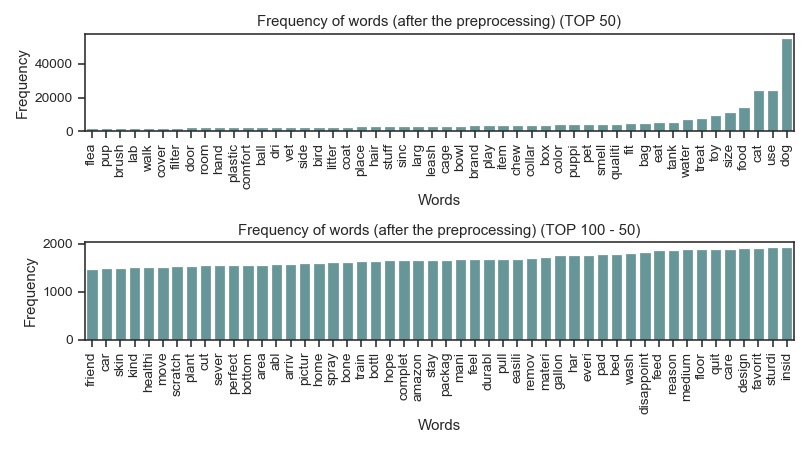

In [107]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_after_sorted.keys())[-50:], y=list(frequency_after_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_after_sorted.keys())[-100:-50], y=list(frequency_after_sorted.values())[-100:-50],
            color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

In [81]:
# Check the number of unique words
len(set(token for review in token_removed_list for token in review))

7278

In [82]:
# Confirm the number of products
len(token_removed_list)

32353

The number has not been changed.

### 2.13. Removing products having 4 or less tokens

In [83]:
# Check the number of tokens per product
number_token_list = [len(tokens) for tokens in token_removed_list]

# Show the minimum and maximum
min(number_token_list), max(number_token_list)

(1, 130)

In [84]:
# Check the number of products having 4 or less tokens
number_token_list.count(1), number_token_list.count(2), number_token_list.count(3), number_token_list.count(4)

(1, 6, 18, 32)

In [85]:
# Remove the products having 4 or less tokens
token_moretokens_list = [token_removed_list[i] for i in range(len(token_removed_list)) 
                         if len(token_removed_list[i]) not in [1,2,3,4]]

# Show the number of the products in token_moretokens_list
len(token_moretokens_list)

32296

In [110]:
# Save token_moretokens_list as a csv file
# with open('token_list_5.csv', 'w', encoding='UTF-8') as f:
#     writer = csv.writer(f, lineterminator='\n')
#     writer.writerows(token_moretokens_list)

In [86]:
# Check the number of tokens per product
number_token_removed_list = [len(tokens) for tokens in token_moretokens_list]

# Show the minimum and maximum
min(number_token_removed_list), max(number_token_removed_list)

(5, 130)

The products having a few tokens have been removed.

<IPython.core.display.Javascript object>


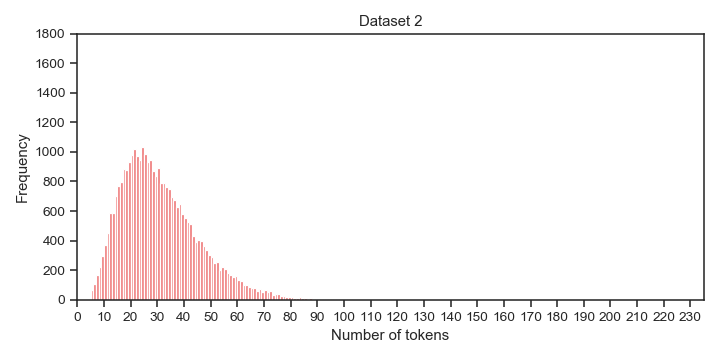

In [108]:

# Draw a cumulative count plot
plt.figure(figsize=(8,4))

plt.hist(number_token_removed_list, bins=125, rwidth=1, color='lightcoral')
plt.xlim([0,235])
plt.ylim([0,1800])
plt.xticks(range(0,235,10))
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Dataset 2')  #Number of tokens / product

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


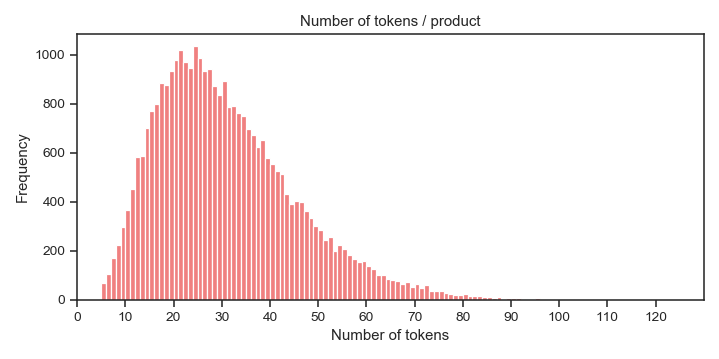

In [109]:
# Draw a cumulative count plot
plt.figure(figsize=(8,4))

plt.hist(number_token_removed_list, bins=125, rwidth=1, color='lightcoral')
plt.xlim([0,130])
plt.xticks(range(0,130,10))
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Number of tokens / product') 

plt.tight_layout()
plt.show()

In [89]:
# Calculate the 90 percentiles
np.percentile(number_token_removed_list, [25, 50, 75, 90])

array([20., 28., 39., 51.])

In [90]:
# Calculate the mean
np.mean(number_token_removed_list)

30.630635372801585

In [91]:
# Calculate the std
np.std(number_token_removed_list)

14.721519959091767

90 % of products have 5 to 51 tokens. The mean was 30.6.

I am making a new id_name table.

In [92]:
# Get the indexes which products have a few tokens
few_tokens_index_list = [i for i in range(len(token_removed_list)) if len(token_removed_list[i]) in [1,2,3,4]]
few_tokens_index_list[:5], len(few_tokens_index_list)

([31, 196, 565, 704, 1015], 57)

In [93]:
# Get product_ids of the products removed
fewtoken_product_id = [id_name.index[i] for i in few_tokens_index_list]
fewtoken_product_id[:5]

[1281995, 5813912, 16557829, 20347466, 30716295]

In [94]:
# Extract several examples of no token products to check them
df_few_token = df_5_reviews[df_5_reviews['product_id'] == 16557829].append(df_5_reviews[df_5_reviews['product_id'] == 20347466]).append(df_5_reviews[df_5_reviews['product_id'] == 30716295])

# Change the setting to be able to see all words
pd.set_option("display.max_colwidth", 100)

# Show the product information
df_few_token

,product_id,product_title,review_body
36179,16557829,Frontline Plus for Dogs - 6 count,Does what it is supposed to do! Great product!
155661,16557829,Frontline Plus for Dogs - 6 count,Exactly as expected! Thank you!
193866,16557829,Frontline Plus for Dogs - 6 count,WORKS WELL .......... FAST SHIP
233249,16557829,Frontline Plus for Dogs - 6 count,Fast delivery and exactly what I expected!!
238171,16557829,Frontline Plus for Dogs - 6 count,Haves used Frontline for years. It does a great job!
35536,20347466,"Polly's Hardwood Bird Perch, Large",My African Grey enjoys standing on this perch.
243750,20347466,"Polly's Hardwood Bird Perch, Large",Really strong and well done.<br />Fuerte y muy bien hecha.
604232,20347466,"Polly's Hardwood Bird Perch, Large",cockatoo has done ate this one up too lol
941640,20347466,"Polly's Hardwood Bird Perch, Large",These are perfect for my macaw.
1241581,20347466,"Polly's Hardwood Bird Perch, Large",My parrots love this perch. It is perfect for their feet.


They are relativery short.

In [95]:
# Make a new id-name list
new_id_name = id_name.drop(fewtoken_product_id)
print(new_id_name)

                                                                                                  product_title
product_id                                                                                                     
17464       Beastie Bands ZEBRA Cat Collar, StripesBeastie Bands ZEBRA Cat Collar, StripesBeastie Bands ZEBR...
23478       YML Double Door Dog Kennel Cage with Plastic Tray No Bottom Wire, 36-Inch, BlackYML Double Door ...
52493       Hartz Groomer's Best Pedicure Kit for Dogs and CatsHartz Groomer's Best Pedicure Kit for Dogs an...
70064       Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...
119780      ARK Naturals PRODUCTS for PETS 326066 4-Ounce Breath-Less Chewable Brushless Toothpaste, MiniARK...
...                                                                                                         ...
999833933   Carlson Secure and Compact Single Door Metal Dog Crate, Extra LargeCarlson Secure and Compac

Table5. Product id - name list (for the model)

In [111]:
# Save Product id-name list as a csv file
# new_id_name.to_csv('product_list_5.csv')

I am making a table for the 43 products removed.

In [96]:
# Create a table of the removed product for later
fewtoken_products = id_name[~id_name.index.isin(new_id_name.index)]
fewtoken_products.head()

,product_title
product_id,
1281995,Professional Dog-Cat-Pet Urine Detector-Urine Finder Light Makes Finding Stains Easy. Free 1 Yea...
5813912,ZGY 14W Soft Adjustable Temperature Pet Reptile Cat Dog Heating Warmer Bed Heater Mat Amphibians...
16557829,Frontline Plus for Dogs - 6 countFrontline Plus for Dogs - 6 countFrontline Plus for Dogs - 6 co...
20347466,"Polly's Hardwood Bird Perch, LargePolly's Hardwood Bird Perch, LargePolly's Hardwood Bird Perch,..."
30716295,Heavy Duty 26' Retractable Dog Leash - 85 LBS CapacityHeavy Duty 26' Retractable Dog Leash - 85 ...


Table6. Few tokens products list

## 3. Exploratory Data Analysis

3.1. The number of products relating to each animal kind  
3.2. The number of products relating to each application type  
3.3. The rough relationship between an animal kind and application type

### 3.1. The number of products relating to each animal kind

Count the rough numbers of products relating to a specific animal.

In [97]:
# Define a function returning the number of products having a specific word as a token
def count_word(word):
    count = 0
    for product in token_moretokens_list:
        if word in product:
            count += 1
    return count

In [98]:
# Count products having 'dog', 'puppi' or 'doggi' as a token
count_dog = count_word('dog')
count_puppi = count_word('puppi')
count_doggi = count_word('doggi')
count_dogs = count_dog + count_puppi + count_doggi
print('Dog:', count_dogs)

# Count products having 'cat', 'kitti', 'kitt' or 'kitten' as a token
count_cat = count_word('cat')
count_kitti = count_word('kitti')
count_kitt = count_word('kitt')
count_kitten = count_word('kitten')
count_cats = count_cat + count_kitti + count_kitt + count_kitten
print('Cat:', count_cats)

# Count products having 'bird' as a token
count_bird = count_word('bird')
count_chick = count_word('chick')
count_birds = count_bird + count_chick
print('Bird:', count_birds)

# Count products having 'fish' as a token
count_fish = count_word('fish')
print('Fish:', count_fish)

# Count products having 'rabit' as a token
count_rabbit = count_word('rabbit')
count_bunni = count_word('bunni')
count_rabbits = count_rabbit + count_bunni
print('Rabbit:', count_rabbits)

Dog: 22364
Cat: 7618
Bird: 1306
Fish: 817
Rabbit: 842


<IPython.core.display.Javascript object>


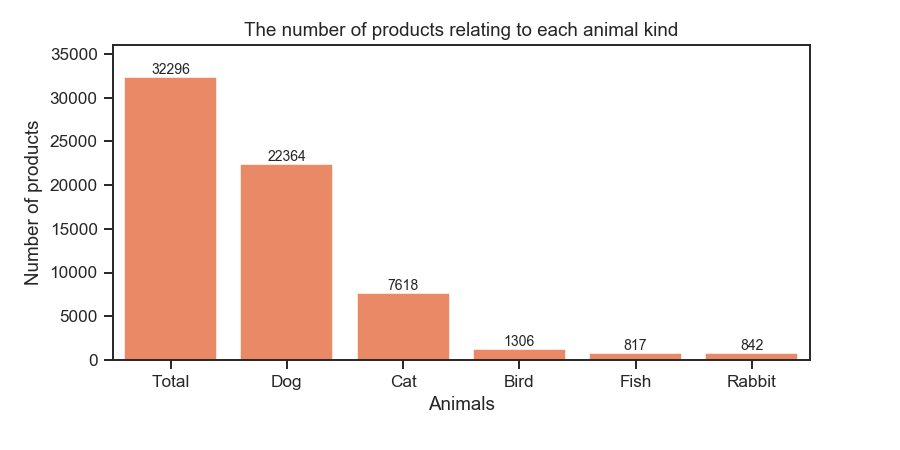

In [99]:
# Draw a bar plot
plt.figure(figsize=(8,4))

X = ['Total', 'Dog', 'Cat', 'Bird', 'Fish', 'Rabbit']
Y = [len(token_moretokens_list), count_dogs, count_cats, count_birds, count_fish, count_rabbits]

p = sns.barplot(x=X, y=Y, color='coral')
plt.xlabel('Animals')
plt.ylabel('Number of products')
plt.ylim([0, 36000])
plt.title('The number of products relating to each animal kind')

for x, y in zip([0, 1, 2, 3, 4, 5], Y):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

The main products were for dogs or cats.

### 3.2. The number of products relating to each application type

Count the rough numbers of products relating to food, treats, toys, toilet, cages, clothes, or collars.

In [100]:
# Count products having 'food', 'dri' or 'wet' as a token
count_food = count_word('food')
count_dri = count_word('dri')
count_wet = count_word('wet')
count_foods = count_food + count_dri + count_wet
print('Food:', count_foods)

# Count products having 'treat', 'snack', or 'cooki' as a token
count_treat = count_word('treat')
count_snack = count_word('snack')
count_cooki = count_word('cooki')
count_treats = count_treat + count_snack + count_cooki
print('Treat:', count_treats)

# Count products having 'toy', 'tunnel', 'ball', 'rope', or 'stuff' as a token
count_toy = count_word('toy')
count_tunnel = count_word('tunnel')
count_ball = count_word('ball')
count_rope = count_word('rope')
count_stuff = count_word('stuff')
count_toys = count_toy + count_tunnel + count_ball + count_rope + count_stuff
print('Toy:', count_toys)

# Count products having 'litter', or 'pad' as a token
count_litter = count_word('litter')
count_pad = count_word('pad')
count_toilet = count_litter + count_pad
print('Toilet:', count_toilet)

# Count products having 'cage', 'crate', 'carrier', or 'kennel' as a token
count_cage = count_word('cage')
count_crate = count_word('crate')
count_carrier = count_word('carrier')
count_kennel = count_word('kennel')
count_cages = count_cage + count_crate + count_carrier + count_kennel
print('Cage:', count_cages)

# Count products having 'shirt', 'coat', 'sweater', or 'costum' as a token
count_shirt = count_word('shirt')
count_coat = count_word('coat')
count_sweater = count_word('sweater')
count_costum = count_word('costum')
count_clothes = count_shirt + count_coat + count_sweater + count_costum
print('Clothes:', count_clothes)

# Count products having 'collar', or 'leash' as a token
count_collar = count_word('collar')
count_leash = count_word('leash')
count_collar_leash = count_collar + count_leash
print('Collar&Leash:', count_collar_leash)

Food: 7409
Treat: 3932
Toy: 7680
Toilet: 1947
Cage: 2463
Clothes: 2473
Collar&Leash: 3243


<IPython.core.display.Javascript object>


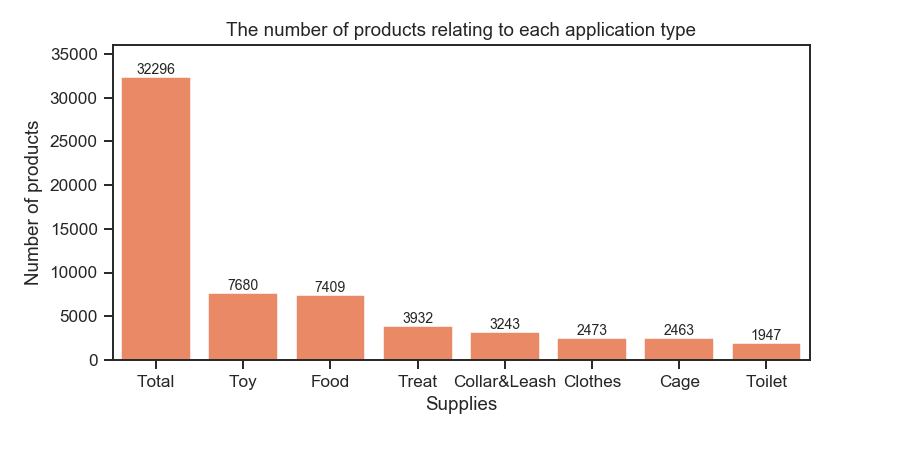

In [101]:
# Draw a bar plot
plt.figure(figsize=(8,4))

X2 = ['Total', 'Toy', 'Food', 'Treat', 'Collar&Leash', 'Clothes', 'Cage', 'Toilet']
Y2 = [len(token_moretokens_list), count_toys, count_foods, count_treats, count_collar_leash, count_clothes,count_cages, count_toilet]

sns.barplot(x=X2, y=Y2, color='coral')
plt.xlabel('Supplies')
plt.ylabel('Number of products')
plt.ylim([0, 36000])
plt.title('The number of products relating to each application type')

for x, y in zip([0, 1, 2, 3, 4, 5, 6, 7], Y2):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

The top 2 categories are Food and Toy, but the products are relatively spread.

### 3.3. The rough relationship between an animal kind and application type

I pick up Dog and Cat as animal kind categories, and Toy and Food as application type categories. Check the relationships between them.

In [102]:
# Define a function making coordinates. word1 and word2 can accept a list.
def make_coordinate(list_name, word1, word2, num):
    for i in range(len(token_moretokens_list)):
        product = token_moretokens_list[i]
        for token in product:
            if token in word1:
                list_name[i][num] += 1
                break
        for token in product:
            if token in word2:
                list_name[i][num] += 2
                break
    return list_name

In [103]:
# Make coorfinates showing the presence of words; dog and/or cat,and toy and/or food
# [1, 0] means the product has 'dog' and doesn't have 'cat', 'toy', or 'food' as the tokens
# [3, 2] means the product has 'dog', 'cat', and 'food' as the tokens

# Make an initial list
animal_supply = [[0, 0] for i in range(len(token_moretokens_list))]

# Make coorfinates
animal_supply = make_coordinate(animal_supply, ['dog','puppi','doggi'], ['cat','kitti','kitt','kitten'] , 0)
animal_supply = make_coordinate(animal_supply, ['toy','tunnel','ball','rope','stuff'], ['food','dri','wet'], 1)
animal_supply[20:30]

[[1, 1],
 [2, 0],
 [1, 0],
 [3, 2],
 [1, 3],
 [2, 0],
 [2, 0],
 [1, 0],
 [1, 0],
 [1, 0]]

<IPython.core.display.Javascript object>


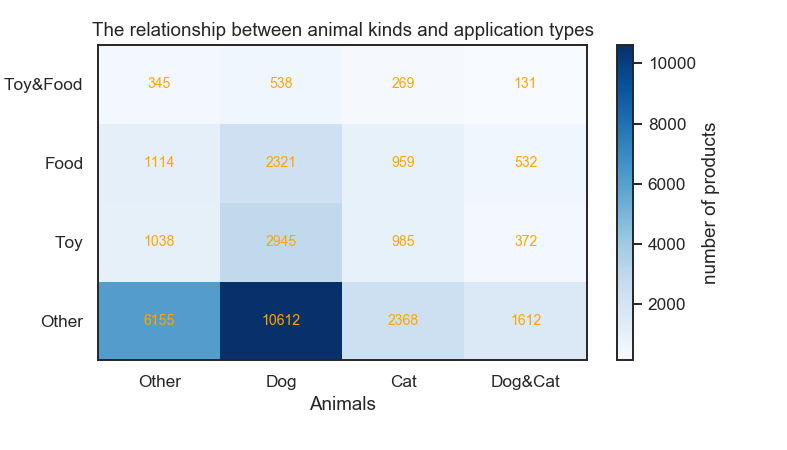

In [104]:
# Make an initial list to draw a pseudocolor plot
mesh_list = [[0,0,0,0], [0,0,0,0],[0,0,0,0],[0,0,0,0]]

# Count the number of products fitting each compartment and make the numpy array
for product in animal_supply:
    mesh_list[product[1]][product[0]] += 1
mesh_arr = np.array(mesh_list)

# Make mesh
u = np.linspace(-1, 1, 5)
v = np.linspace(-1, 1, 5)
X,Y = np.meshgrid(u, v)

# Draw a pseudocolor plot
plt.figure(figsize=(7,4))
plt.pcolor(mesh_arr, cmap='Blues')
pp = plt.colorbar()
pp.set_label('number of products')
plt.xticks(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['','Other', '', 'Dog', '', 'Cat', '', 'Dog&Cat', ''])
plt.yticks(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['','Other', '', 'Toy', '', 'Food', '', 'Toy&Food', ''])
plt.tick_params(bottom=False, left=False)
plt.xlabel('Animals')
plt.ylabel('Supplies')
plt.title('The relationship between animal kinds and application types')

for y in [0.5, 1.5, 2.5, 3.5]:
    for x in [0.5, 1.5, 2.5, 3.5]: 
        plt.text(x, y, mesh_list[int(y-0.5)][int(x-0.5)], ha='center', va='center', fontsize=9, color='orange')

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

Food and toys for dogs are the largest two categories on the chart, but many products are in Other. I will categorize them more precisely in the modeling part of this project. 

The modeling part is showed in a different jupyter notebook. See a jupyter notebook for modeling. 